In [506]:
import yfinance as yf
data = yf.download('Reliance.NS', start="2021-10-21", end="2022-02-16", progress = False)
data.reset_index(inplace=True)

data = data.reset_index()
print(data.columns)
print(data["Date"].dtype)

MultiIndex([( 'index',            ''),
            (  'Date',            ''),
            ( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])
datetime64[ns]


In [507]:
import pandas as pd
sent_df = pd.read_csv('/Users/gursheelsingh/Downloads/reliance_news_sentiment.csv')
sent_df["date"] = pd.to_datetime(sent_df["published_at"]).dt.date

# Map sentiment to numeric
sentiment_map = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

sent_df["sentiment_num"] = sent_df["sentiment"].map(sentiment_map)

sent_daily = sent_df[['date', 'sentiment_num']].rename(
    columns={"date": "Date"}
)

sent_daily.head(20)


,Date,sentiment_num
0,2021-10-21,0
1,2021-10-21,0
2,2021-10-21,-1
3,2021-10-21,0
4,2021-10-21,1
5,2021-10-21,0
6,2021-10-21,0
7,2021-10-21,0
8,2021-10-21,0
9,2021-10-21,1


In [508]:
# print(sent_daily["sentiment_num"].dtype)
# print(sent_daily["sentiment_num"].unique()[:20])
# sent_daily["sentiment_num"].describe()
# sent_daily["sentiment_num"].isna().sum()
# sent_daily["sentiment_num"] = sent_daily["sentiment_num"].fillna(0)


In [509]:
# sent_daily["Date"] = pd.to_datetime(sent_daily["Date"]).dt.date

sent_daily2 = (
    sent_daily
    .groupby("Date")["sentiment_num"]
    .mean()
    .reset_index()
)
sent_daily2.head()



,Date,sentiment_num
0,2021-10-21,0.100000
1,2021-10-22,-0.333333
2,2021-10-24,0.000000
3,2021-10-25,-0.166667
4,2021-10-26,0.100000


In [510]:
import numpy as np

sent_daily["sentiment_bucket"] = np.where(
    sent_daily["sentiment_num"] <= -0.2, -1,
    np.where(
        sent_daily["sentiment_num"] <= 0.2, 0, 1
    )
)


In [511]:
sent_daily[["sentiment_num", "sentiment_bucket"]].head(20)
sent_daily["sentiment_bucket"].value_counts()


sentiment_bucket
 0    417
 1    133
-1    103
Name: count, dtype: int64

In [512]:
sent_daily["sentiment_num"] = sent_daily["sentiment_bucket"]
sent_daily.drop(columns=["sentiment_bucket"], inplace=True)


In [503]:
# import numpy as np

# conditions = [
#     sent_daily_new["sentiment_num"] <= 0.1,
#     (sent_daily_new["sentiment_num"] > 0.1) & (sent_daily_new["sentiment_num"] <= 0.5),
#     sent_daily_new["sentiment_num"] > 0.5
# ]

# choices = [-1, 0, 1]

# sent_daily_new["sentiment_bucket"] = np.select(conditions, choices)
# print(sent_daily_new["sentiment_bucket"].value_counts())
# sent_daily_new.head()


In [504]:
# sent_daily_new["sentiment_num"] = sent_daily_new["sentiment_bucket"]
# sent_daily_new.drop(columns=["sentiment_bucket"], inplace=True)



In [513]:

# handling MultiIndex columns completely
data.columns = ['_'.join(col).strip() for col in data.columns.values]

print(data.columns)


data.head()





Index(['index_', 'Date_', 'Close_RELIANCE.NS', 'High_RELIANCE.NS',
       'Low_RELIANCE.NS', 'Open_RELIANCE.NS', 'Volume_RELIANCE.NS'],
      dtype='object')


,index_,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS
0,0,2021-10-21,1193.269165,1241.272938,1184.487397,1240.999975,20831669
1,1,2021-10-22,1195.498657,1212.561639,1188.263923,1192.131507,11027475
2,2,2021-10-25,1183.850220,1219.432227,1169.380873,1219.432227,17198417
3,3,2021-10-26,1210.809814,1214.381688,1184.464631,1190.812114,9750178
4,4,2021-10-27,1195.498657,1217.976256,1192.108760,1206.691963,9896298


In [514]:
import numpy as np
data["log_return"] = np.log(
    data["Close_RELIANCE.NS"] / data["Close_RELIANCE.NS"].shift(1)
)

def compute_macd(series, fast=5, slow=20, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    macd_hist = macd - signal_line
    return macd_hist

data["macd"] = compute_macd(data["Close_RELIANCE.NS"])

data["volatility_20"] = data["log_return"].rolling(20).std()


In [515]:
import pandas as pd

def compute_rsi(df, price_col="Close_RELIANCE.NS", window=14):
    delta = df[price_col].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    #preventing divide-by-zero
    avg_loss = avg_loss.replace(0, 1e-10)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi



In [516]:
data["rsi_14"] = compute_rsi(data, price_col="Close_RELIANCE.NS", window=14)
# data["rsi_14"] = data["rsi_14"].fillna(data["rsi_14"].mean())
# data['rsi_14'].head(20)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

# print("Any NaNs left?", data.isna().sum().sum())


In [517]:
df = data.copy()
df.head()
# df[features].describe()

,index_,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS,log_return,macd,volatility_20,rsi_14
20,20,2021-11-22,1075.534790,1114.324603,1069.733354,1108.454927,24124307,-0.045304,-15.219898,0.015859,20.463668
21,21,2021-11-23,1085.590454,1092.597719,1050.622853,1061.565822,25326999,0.009306,-15.927298,0.016118,27.040295
22,22,2021-11-24,1069.915161,1096.533301,1066.343289,1082.928461,16820296,-0.014545,-17.052509,0.016230,23.539353
23,23,2021-11-25,1134.322144,1138.440064,1072.531559,1079.743546,42401936,0.058456,-2.899414,0.020792,52.621233
24,24,2021-11-26,1097.761963,1127.337690,1092.711298,1122.878566,15763138,-0.032762,-2.070068,0.021734,42.126659


<Axes: >

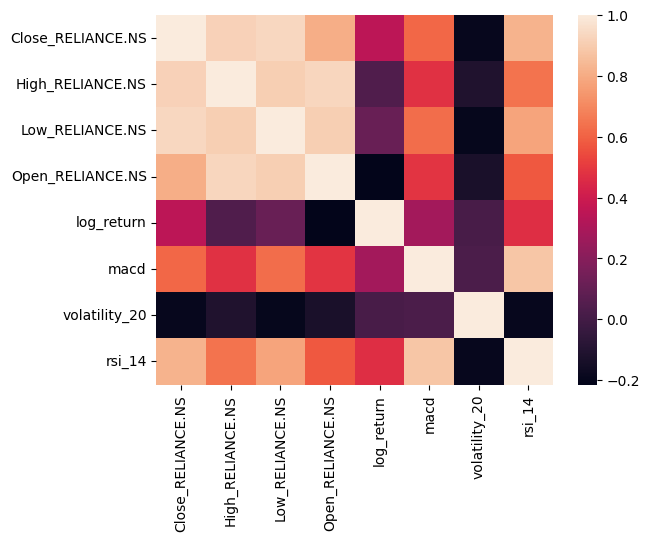

In [518]:
import seaborn as sns
numeric_df = df.select_dtypes(include=["float64"])
correlation = numeric_df.corr()

correlation = numeric_df.corr()
sns.heatmap(correlation)

From the above I found that Close, ma_5 and ma_20 are nearly same therefore can drop them as they may make more noise 


In [519]:
df_final = df

61


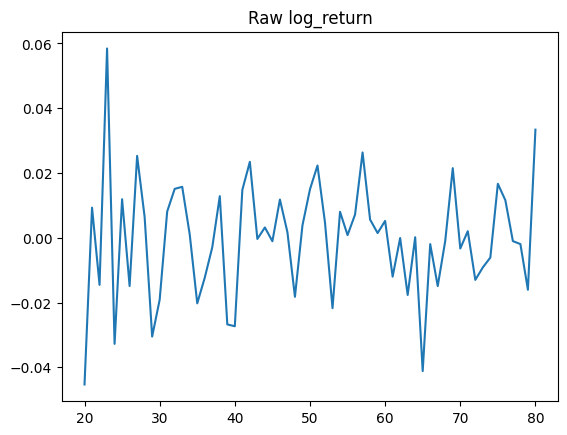

In [520]:
df["log_return"].plot(title="Raw log_return")
print(df["log_return"].nunique())


In [521]:
df_final["Date"] = pd.to_datetime(df_final["Date_"]).dt.date

# Merge sentiment
df_final = df_final.merge(
    sent_daily_new,
    on="Date",
    how="left"
)

# Check
df_final[["Date", "sentiment_num"]].tail(20)
df_final["sentiment_num"] = df_final["sentiment_num"].fillna(0)


In [526]:
df_final = df_final.replace([np.inf, -np.inf], np.nan)
df_final = df_final.dropna(subset=features)

In [525]:
features = [
    "log_return",          
    "Open_RELIANCE.NS",
    "High_RELIANCE.NS",
    "Low_RELIANCE.NS",
    "Close_RELIANCE.NS",
    "Volume_RELIANCE.NS",
    'sentiment_num',
    "rsi_14",
    "macd",
    "volatility_20"
]

target = "log_return"

# print(data["rsi_14"].head(20))
# print(data["rsi_14"].isna().sum())

# df_final[features].describe()
# df_final['returns_'].head()
df_final.head()

,index_,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS,log_return,macd,volatility_20,rsi_14,Date,sentiment_num
0,20,2021-11-22,1075.534790,1114.324603,1069.733354,1108.454927,24124307,-0.045304,-15.219898,0.015859,20.463668,2021-11-22,1
1,21,2021-11-23,1085.590454,1092.597719,1050.622853,1061.565822,25326999,0.009306,-15.927298,0.016118,27.040295,2021-11-23,0
2,22,2021-11-24,1069.915161,1096.533301,1066.343289,1082.928461,16820296,-0.014545,-17.052509,0.016230,23.539353,2021-11-24,-1
3,23,2021-11-25,1134.322144,1138.440064,1072.531559,1079.743546,42401936,0.058456,-2.899414,0.020792,52.621233,2021-11-25,1
4,24,2021-11-26,1097.761963,1127.337690,1092.711298,1122.878566,15763138,-0.032762,-2.070068,0.021734,42.126659,2021-11-26,0


In [527]:
print("df rows:", len(df))
print("df_final rows:", len(df_final))

print("\nDuplicate dates in df_final:")
print(df_final["Date"].value_counts().head(10))


df rows: 61
df_final rows: 61

Duplicate dates in df_final:
Date
2021-11-22    1
2022-01-04    1
2022-01-06    1
2022-01-07    1
2022-01-10    1
2022-01-11    1
2022-01-12    1
2022-01-13    1
2022-01-14    1
2022-01-17    1
Name: count, dtype: int64


61


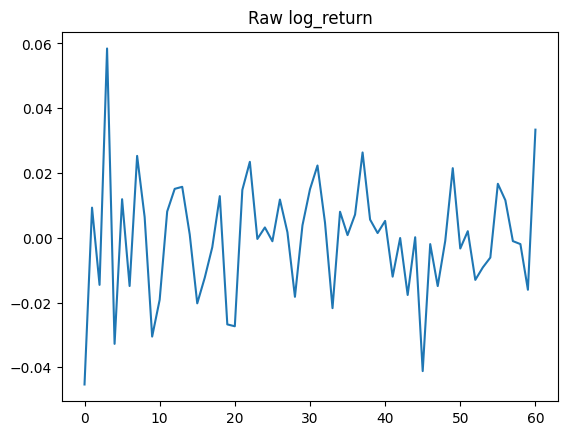

In [528]:
df_final["log_return"].plot(title="Raw log_return")
print(df_final["log_return"].nunique())


LSTM Architecture

In [529]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state h0 and cell state c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))

        # Take output of the last time step
        out = out[:, -1, :]

        # Final prediction
        prediction = self.fc(out)

        return prediction

In [531]:
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 15

X = df_final[features].values
y = df_final[target].values

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

In [532]:
split = int(0.8 * len(X_seq))

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


In [533]:
print("X shape:", X.shape)
print("X_seq shape:", X_seq.shape)
print("X_train shape:", X_train.shape)


X shape: (61, 10)
X_seq shape: (46, 15, 10)
X_train shape: (36, 15, 10)


In [534]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (36, 15, 10)
X_val shape: (10, 15, 10)


# Scaling the data by converting the 3D x to 2D and then back to 3D

In [535]:
from sklearn.preprocessing import StandardScaler
# Scale X

n_train, t_train, f_train = X_train.shape
n_val,   t_val,   f_val   = X_val.shape

X_train_2d = X_train.reshape(-1, f_train)
X_val_2d   = X_val.reshape(-1, f_val)

scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_val_scaled_2d   = scaler_X.transform(X_val_2d)

X_train_s = X_train_scaled_2d.reshape(n_train, t_train, f_train)
X_val_s   = X_val_scaled_2d.reshape(n_val, t_val, f_val)


# Scale y

scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s   = scaler_y.transform(y_val.reshape(-1,1))




Using the self made model

In [536]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


input_dim = X_train.shape[2]     
hidden_dim = 256               
num_layers = 3                

model = SentimentLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


In [537]:
X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_s, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_s, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val_s, dtype=torch.float32).to(device)


# y_train_t = y_train_t.unsqueeze(1)
# y_val_t = y_val_t.unsqueeze(1)

print("X_train shape:", X_train_t.shape)  
print("y_train shape:", y_train_t.shape) 

X_train shape: torch.Size([36, 15, 10])
y_train shape: torch.Size([36, 1])


In [538]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train_t)          # forward pass
    loss = criterion(preds, y_train_t)

    loss.backward()
    optimizer.step()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {loss.item():.6f} | "
        f"Val Loss: {val_loss.item():.6f}"
    )

Epoch 01 | Train Loss: 0.998910 | Val Loss: 0.896223
Epoch 02 | Train Loss: 0.981459 | Val Loss: 0.879672
Epoch 03 | Train Loss: 0.960698 | Val Loss: 0.858540
Epoch 04 | Train Loss: 0.922087 | Val Loss: 0.831019
Epoch 05 | Train Loss: 0.884479 | Val Loss: 0.852605
Epoch 06 | Train Loss: 0.896273 | Val Loss: 0.912307
Epoch 07 | Train Loss: 0.860050 | Val Loss: 0.916948
Epoch 08 | Train Loss: 0.839008 | Val Loss: 0.905455
Epoch 09 | Train Loss: 0.832003 | Val Loss: 0.900604
Epoch 10 | Train Loss: 0.825304 | Val Loss: 0.908825
Epoch 11 | Train Loss: 0.794848 | Val Loss: 0.940847
Epoch 12 | Train Loss: 0.781573 | Val Loss: 1.015655
Epoch 13 | Train Loss: 0.772124 | Val Loss: 1.107415
Epoch 14 | Train Loss: 0.764871 | Val Loss: 1.126763
Epoch 15 | Train Loss: 0.759540 | Val Loss: 1.074666
Epoch 16 | Train Loss: 0.745669 | Val Loss: 1.016556
Epoch 17 | Train Loss: 0.735670 | Val Loss: 0.967597
Epoch 18 | Train Loss: 0.711753 | Val Loss: 0.927505
Epoch 19 | Train Loss: 0.689109 | Val Loss: 0.

In [539]:
model.eval()
with torch.no_grad():
    preds = model(X_val_t).cpu().numpy().flatten()


actual = y_val_t.cpu().numpy().flatten()


In [540]:
preds  = scaler_y.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler_y.inverse_transform(actual.reshape(-1,1)).flatten()


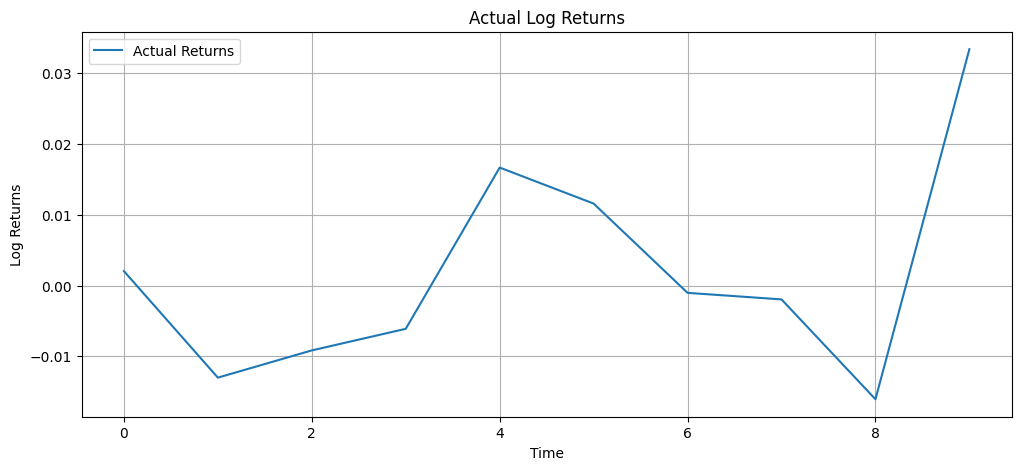

In [541]:
with torch.no_grad():
    preds_scaled = model(X_val_t).cpu().numpy().flatten()

preds_real = scaler_y.inverse_transform(
    preds_scaled.reshape(-1,1)
).ravel()

actual_real = actual    # already real

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(actual_real, label="Actual Returns")
plt.xlabel("Time")
plt.ylabel("Log Returns")
plt.title("Actual Log Returns")
plt.legend()
plt.grid(True)
plt.show()

In [542]:
def pred_future_combined(
    model,
    df,
    features,
    target,
    window_size=30,
    n_future=30,
    device="cpu"
):

    # roll_features = base_features + [target]
    model.eval()

    last_window = df[features].iloc[-window_size:].values
    future_preds = []
    current_window = last_window.copy()

    target_idx = features.index(target)

    for step in range(n_future):

        X_input = current_window.reshape(1, window_size, len(features))
        X_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)

        with torch.no_grad():
            pred = model(X_tensor)

        pred_value = float(pred.cpu().numpy().flatten()[0])
        future_preds.append(pred_value)

        new_row = current_window[-1].copy()
        new_row[target_idx] = pred_value
        current_window = np.vstack([current_window[1:], new_row])

    return future_preds


In [543]:
future_prices = pred_future_combined(
    model=model,
    df=df_final,
    features=features,
    target="log_return",
    window_size=30,
    n_future=30
)

In [544]:
# import numpy as np

# actual_arr = np.array(actual, dtype=float)
# preds_arr = np.array(preds, dtype=float)
# future_arr = np.array(future_prices, dtype=float)


In [545]:

# # Inverse transform (back to real price scale)
# actual_real = actual_arr
# preds_real  = scaler_y.inverse_transform(preds_arr.reshape(-1, 1)).ravel()
# future_real = scaler_y.inverse_transform(future_arr.reshape(-1, 1)).ravel()



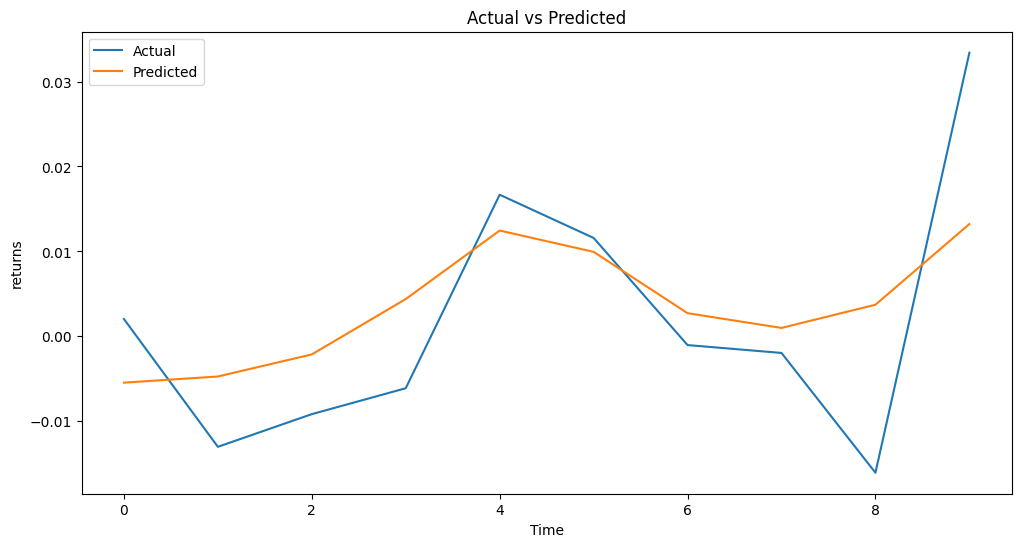

In [546]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

plt.plot(actual_real, label="Actual")
plt.plot(preds_real, label="Predicted")



plt.xlabel("Time")
plt.ylabel("returns")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()


In [547]:
df_final.shape

(61, 13)

In [548]:
print("Unique actual values (first 20):")
print(np.unique(actual_real[:50]))

print("Total unique values:", len(np.unique(actual_real)))


Unique actual values (first 20):
[-0.01605562 -0.01300604 -0.00915881 -0.00610966 -0.00195475 -0.00102851
  0.00203683  0.01158365  0.01667003  0.03338897]
Total unique values: 10


Prediction Using the Model imported from KERAS

In [549]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


In [562]:
model = Sequential([
    LSTM(64, input_shape=(X_train_s.shape[1], X_train_s.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

/opt/anaconda3/envs/market_mood_2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [565]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=50,
    batch_size=2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9564 - mean_absolute_error: 0.7722 - val_loss: 0.9379 - val_mean_absolute_error: 0.8385
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8067 - mean_absolute_error: 0.6967 - val_loss: 0.9369 - val_mean_absolute_error: 0.8384
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7904 - mean_absolute_error: 0.7058 - val_loss: 0.9564 - val_mean_absolute_error: 0.8483
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8373 - mean_absolute_error: 0.6904 - val_loss: 0.9667 - val_mean_absolute_error: 0.8497
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8416 - mean_absolute_error: 0.7312 - val_loss: 0.9561 - val_mean_absolute_error: 0.8468
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7421 - mean_absolute_error: 0.6575 - val_loss: 0.9530 - val_mean_absolute_error: 0.8437
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7808 - mean_absolute_error: 0.6762 - val_loss: 0.976

In [566]:
preds_scaled = model.predict(X_val_s)

preds_real = scaler_y.inverse_transform(preds_scaled).ravel()
actual_real = y_val


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
